# Загрузка данных


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from pymorphy2 import MorphAnalyzer
import re
import numpy as np

In [44]:
df = pd.read_csv('dataset.csv')

Сделаем первичную обработку текста - все буквы строчные, уберем переводы строк, лишние пробелы и все знаки, которые не буквы или числа

# Предобработка данных

In [45]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text) 
    text = re.sub(r'[^а-яa-z0-9 ]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['clean_text'] = df['text'].apply(clean_text)

Закодируем главную рубрику

In [46]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['main_rubric'])

Примеры рубрик и их лейблов

In [47]:
dict(zip(le.classes_, range(len(le.classes_))))

{'АЗС': 0,
 'Автомойка': 1,
 'Аквапарк': 2,
 'Антикафе': 3,
 'Аренда площадок для культурно-массовых мероприятий': 4,
 'Аренда теплоходов': 5,
 'Аренда фотостудий': 6,
 'Аттракцион': 7,
 'База, дом отдыха': 8,
 'Банкетный зал': 9,
 'Баня': 10,
 'Бар, паб': 11,
 'Барбершоп': 12,
 'Бассейн': 13,
 'Батутный центр': 14,
 'Бильярдный клуб': 15,
 'Боулинг-клуб': 16,
 'Быстрое питание': 17,
 'Верёвочный парк': 18,
 'Вина и винные напитки оптом': 19,
 'Выставочный центр': 20,
 'Гипермаркет': 21,
 'Горнолыжный комплекс': 22,
 'Гостиница': 23,
 'Детейлинг': 24,
 'Детская площадка': 25,
 'Детский лагерь отдыха': 26,
 'Доставка еды и обедов': 27,
 'Достопримечательность': 28,
 'Зоопарк': 29,
 'Игровая комната': 30,
 'Кальян-бар': 31,
 'Караоке-клуб': 32,
 'Картинг': 33,
 'Каток': 34,
 'Кафе': 35,
 'Квесты': 36,
 'Кейтеринг': 37,
 'Кемпинг': 38,
 'Кинотеатр': 39,
 'Клуб охотников и рыболовов': 40,
 'Компьютерный клуб': 41,
 'Кондитерская': 42,
 'Кондитерские изделия оптом': 43,
 'Концертный зал': 4

In [73]:
all_texts = df['clean_text'].values
all_labels = df['label'].values

train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    all_texts,
    all_labels,
    test_size=0.2,
    random_state=42,
    stratify=all_labels
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts,
    train_val_labels,
    test_size=0.25, 
    random_state=42,
    stratify=train_val_labels
)

print(f"Размер обучающей выборки: {len(train_texts)}")
print(f"Размер валидационной выборки: {len(val_texts)}")
print(f"Размер тестовой выборки: {len(test_texts)}")

Размер обучающей выборки: 43470
Размер валидационной выборки: 14490
Размер тестовой выборки: 14491


Создание словаря (токенизатор)

In [55]:
from multiprocessing import Pool
from functools import lru_cache
from tqdm import tqdm

morph = MorphAnalyzer()

@lru_cache(maxsize=50000) 
def normalize_word(word):
    parsed = morph.parse(word)[0]
    return parsed.normal_form

def process_text(text):
    return [normalize_word(word) for word in text.split()]

def normalize_text_parallel(texts, workers=8):
    with Pool(processes=workers) as pool:
        normalized = list(tqdm(
            pool.imap(process_text, texts),
            total=len(texts),
            desc="Нормализация текстов"
        ))
    return normalized

def build_vocab_fast(texts, min_freq=2, workers=8):
    normalized_texts = normalize_text_parallel(texts, workers=workers)
    
    counter = Counter()
    for words in normalized_texts:
        counter.update(words)
    
    vocab = {'<PAD>':0, '<UNK>':1}
    idx = 2
    for word, freq in counter.items():
        if freq >= min_freq and word:
            vocab[word] = idx
            idx += 1
    
    return vocab


In [56]:
vocab = build_vocab_fast(train_texts)
print(f"Размер словаря: {len(vocab)}")

Нормализация текстов: 100%|██████████| 57960/57960 [00:16<00:00, 3611.39it/s]


Размер словаря: 23485


Заменяем слова на индексы

In [57]:
def text_to_indices(text, vocab):
    tokens = text.split()
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

Представляем отзывы в правильном для торча формате

In [74]:
train_sequences = [torch.tensor(text_to_indices(text, vocab)) for text in train_texts]
val_sequences = [torch.tensor(text_to_indices(text, vocab)) for text in val_texts]
test_sequences = [torch.tensor(text_to_indices(text, vocab)) for text in test_texts]

class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = TextDataset(train_sequences, train_labels)
val_dataset = TextDataset(val_sequences, val_labels)
test_dataset = TextDataset(test_sequences, test_labels)

def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=vocab['<PAD>'])
    labels = torch.stack(labels)
    return sequences_padded, labels

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# CNN

In [75]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [79]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, kernel_sizes=[3,4,5], num_filters=100, dropout=0.7):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embed_dim)) for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)
    
    def forward(self, x):
        x = self.embedding(x) 
        x = x.unsqueeze(1) 
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]  
        x = [F.max_pool1d(item, item.size(2)).squeeze(2) for item in x]  
        x = torch.cat(x, 1) 
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

Начало обучения с использованием валидационной выборки...
Epoch 1/50
  Train -> loss: 1.9948, acc: 0.4394, f1: 0.0099
  Valid -> loss: 1.7504, acc: 0.4905, f1: 0.0113
  Улучшение на валидации! Модель сохранена
Epoch 2/50
  Train -> loss: 1.7871, acc: 0.4838, f1: 0.0148
  Valid -> loss: 1.6733, acc: 0.5056, f1: 0.0171
  Улучшение на валидации! Модель сохранена
Epoch 3/50
  Train -> loss: 1.7135, acc: 0.4951, f1: 0.0200
  Valid -> loss: 1.6244, acc: 0.5111, f1: 0.0203
  Улучшение на валидации! Модель сохранена
Epoch 4/50
  Train -> loss: 1.6668, acc: 0.5020, f1: 0.0236
  Valid -> loss: 1.5942, acc: 0.5211, f1: 0.0272
  Улучшение на валидации! Модель сохранена
Epoch 5/50
  Train -> loss: 1.6334, acc: 0.5111, f1: 0.0269
  Valid -> loss: 1.5833, acc: 0.5179, f1: 0.0258
  Улучшение на валидации! Модель сохранена
Epoch 6/50
  Train -> loss: 1.6088, acc: 0.5116, f1: 0.0283
  Valid -> loss: 1.5616, acc: 0.5239, f1: 0.0291
  Улучшение на валидации! Модель сохранена
Epoch 7/50
  Train -> loss: 1.

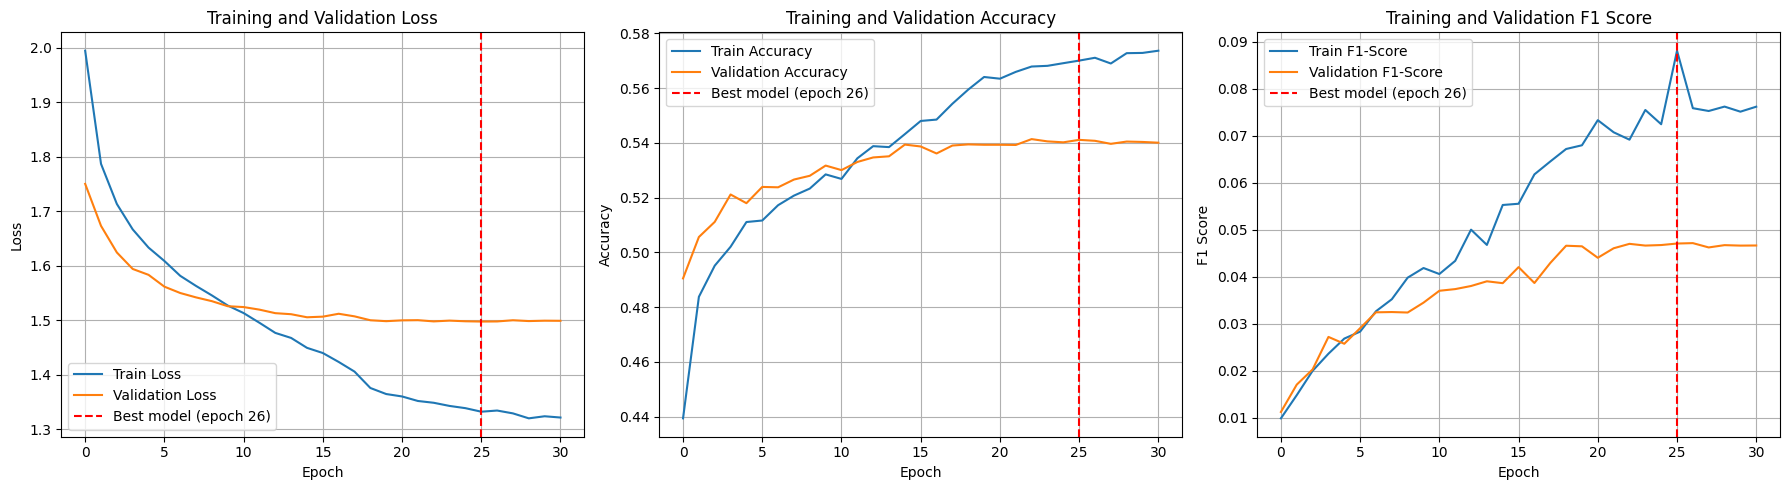

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return total_loss / len(dataloader), acc, f1

def eval_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch_y.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return total_loss / len(dataloader), acc, f1


VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 100
NUM_CLASSES = len(le.classes_)
EPOCHS = 50
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-5

model = TextCNN(VOCAB_SIZE, EMBEDDING_DIM, NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2)

train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_f1s, val_f1s = [], []

best_val_loss = float('inf')
epochs_no_improve = 0
patience = 5
best_model_path = 'best_model_on_validation.pth'

print("Начало обучения с использованием валидационной выборки...")
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1 = eval_model(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss) 
    train_accs.append(train_acc)
    val_accs.append(val_acc)    
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)    
    
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"  Train -> loss: {train_loss:.4f}, acc: {train_acc:.4f}, f1: {train_f1:.4f}")
    print(f"  Valid -> loss: {val_loss:.4f}, acc: {val_acc:.4f}, f1: {val_f1:.4f}")
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"  Улучшение на валидации! Модель сохранена")
    else:
        epochs_no_improve += 1
        print(f"  Улучшения на валидации нет {epochs_no_improve}/{patience}\n")

    if epochs_no_improve >= patience:
        print(f"Ранняя остановка на эпохе {epoch}. Лучшая val loss: {best_val_loss:.4f}")
        break


print("\nОбучение завершено.")
print(f"Загрузка лучшей модели из {best_model_path} для финальной оценки на тестовых данных.")
model.load_state_dict(torch.load(best_model_path))

test_loss, test_acc, test_f1 = eval_model(model, test_loader, criterion, device)

print("\n--- Финальные метрики лучшей модели на тестовых данных ---")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} | Test F1-Score (macro): {test_f1:.4f}")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss') 
best_epoch = np.argmin(val_losses)
plt.axvline(best_epoch, linestyle='--', color='r', label=f'Best model (epoch {best_epoch+1})')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy') 
plt.axvline(best_epoch, linestyle='--', color='r', label=f'Best model (epoch {best_epoch+1})')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(train_f1s, label='Train F1-Score')
plt.plot(val_f1s, label='Validation F1-Score')
plt.axvline(best_epoch, linestyle='--', color='r', label=f'Best model (epoch {best_epoch+1})')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# LSTM

In [81]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=2, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, 
                           bidirectional=True, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        embedded = self.dropout(self.embedding(x)) 
    
        output, (hidden, cell) = self.lstm(embedded)
        
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1) 
        
        hidden = self.dropout(hidden)
        return self.fc(hidden)

Начало обучения LSTM модели...
Epoch 1/30
  Train -> loss: 1.9453, acc: 0.4461, f1: 0.0075
  Valid -> loss: 1.8071, acc: 0.4712, f1: 0.0086
  Улучшение на валидации! Модель сохранена
Epoch 2/30
  Train -> loss: 1.8064, acc: 0.4687, f1: 0.0093
  Valid -> loss: 1.7361, acc: 0.4881, f1: 0.0104
  Улучшение на валидации! Модель сохранена
Epoch 3/30
  Train -> loss: 1.7375, acc: 0.4853, f1: 0.0121
  Valid -> loss: 1.6569, acc: 0.5046, f1: 0.0163
  Улучшение на валидации! Модель сохранена
Epoch 4/30
  Train -> loss: 1.6776, acc: 0.4980, f1: 0.0177
  Valid -> loss: 1.6021, acc: 0.5141, f1: 0.0214
  Улучшение на валидации! Модель сохранена
Epoch 5/30
  Train -> loss: 1.6414, acc: 0.5035, f1: 0.0206
  Valid -> loss: 1.5865, acc: 0.5170, f1: 0.0249
  Улучшение на валидации! Модель сохранена
Epoch 6/30
  Train -> loss: 1.6076, acc: 0.5093, f1: 0.0247
  Valid -> loss: 1.5556, acc: 0.5203, f1: 0.0278
  Улучшение на валидации! Модель сохранена
Epoch 7/30
  Train -> loss: 1.5791, acc: 0.5141, f1: 0.02

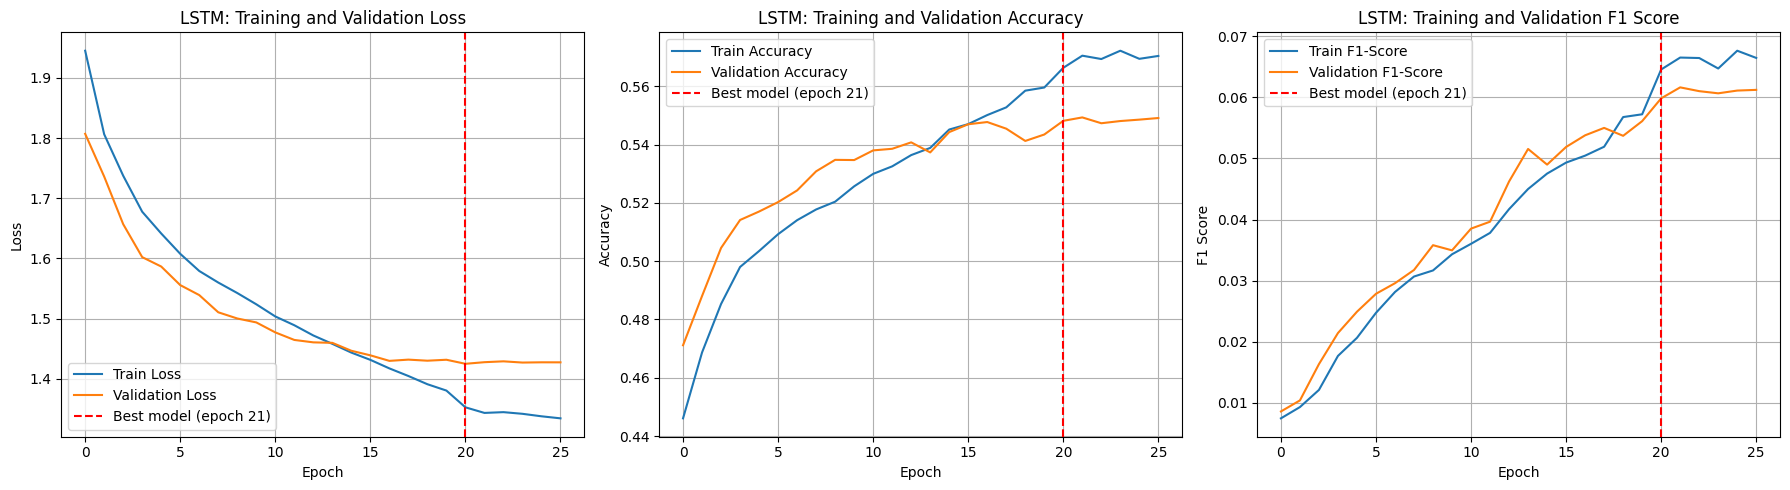

In [82]:
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
NUM_CLASSES = len(le.classes_)
EPOCHS = 30 
LEARNING_RATE = 3e-4 
WEIGHT_DECAY = 1e-5 

lstm_model = LSTMClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2)

lstm_train_losses, lstm_val_losses = [], []
lstm_train_accs, lstm_val_accs = [], []
lstm_train_f1s, lstm_val_f1s = [], []

best_val_loss = float('inf')
epochs_no_improve = 0
patience = 5
best_lstm_model_path = 'best_lstm_model.pth'

print("Начало обучения LSTM модели...")
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc, train_f1 = train_epoch(lstm_model, train_loader, criterion, optimizer, device)
    
    val_loss, val_acc, val_f1 = eval_model(lstm_model, val_loader, criterion, device)
    
    lstm_train_losses.append(train_loss)
    lstm_val_losses.append(val_loss)
    lstm_train_accs.append(train_acc)
    lstm_val_accs.append(val_acc)
    lstm_train_f1s.append(train_f1)
    lstm_val_f1s.append(val_f1)
    
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"  Train -> loss: {train_loss:.4f}, acc: {train_acc:.4f}, f1: {train_f1:.4f}")
    print(f"  Valid -> loss: {val_loss:.4f}, acc: {val_acc:.4f}, f1: {val_f1:.4f}")
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(lstm_model.state_dict(), best_lstm_model_path)
        print(f"  Улучшение на валидации! Модель сохранена")
    else:
        epochs_no_improve += 1
        print(f"  Улучшения на валидации нет {epochs_no_improve}/{patience}\n")

    if epochs_no_improve >= patience:
        print(f"Ранняя остановка на эпохе {epoch}. Лучшая val loss: {best_val_loss:.4f}")
        break

print("\nОбучение завершено.")
print(f"Загрузка лучшей LSTM модели из {best_lstm_model_path} для финальной оценки.")
lstm_model.load_state_dict(torch.load(best_lstm_model_path))

test_loss, test_acc, test_f1 = eval_model(lstm_model, test_loader, criterion, device)

print("\n--- Финальные метрики лучшей LSTM модели на тестовых данных ---")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} | Test F1-Score (macro): {test_f1:.4f}")


plt.figure(figsize=(18, 5))
best_epoch = np.argmin(lstm_val_losses)

plt.subplot(1, 3, 1)
plt.plot(lstm_train_losses, label='Train Loss')
plt.plot(lstm_val_losses, label='Validation Loss')
plt.axvline(best_epoch, linestyle='--', color='r', label=f'Best model (epoch {best_epoch+1})')
plt.title('LSTM: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(lstm_train_accs, label='Train Accuracy')
plt.plot(lstm_val_accs, label='Validation Accuracy')
plt.axvline(best_epoch, linestyle='--', color='r', label=f'Best model (epoch {best_epoch+1})')
plt.title('LSTM: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(lstm_train_f1s, label='Train F1-Score')
plt.plot(lstm_val_f1s, label='Validation F1-Score')
plt.axvline(best_epoch, linestyle='--', color='r', label=f'Best model (epoch {best_epoch+1})')
plt.title('LSTM: Training and Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ruBERT

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-06-24 21:24:23.377071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-24 21:24:28.060742: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [88]:
class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }
    
def train_epoch_bert(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss, all_preds, all_labels = 0, [], []
    
    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        model.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Помогает от "взрыва градиентов"
        optimizer.step()
        scheduler.step()
        
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    return total_loss / len(dataloader), acc, f1

def eval_model_bert(model, dataloader, device):
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            total_loss += outputs.loss.item()
            
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    return total_loss / len(dataloader), acc, f1

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/15 ---


Evaluating: 100%|██████████| 453/453 [00:10<00:00, 43.19it/s]


  Train -> loss: 2.0711, acc: 0.4663, f1: 0.0088
  Valid -> loss: 1.7134, acc: 0.4992, f1: 0.0113
  Улучшение на валидации! Модель сохранена

--- Epoch 2/15 ---


Evaluating: 100%|██████████| 453/453 [00:10<00:00, 43.30it/s]


  Train -> loss: 1.6471, acc: 0.5114, f1: 0.0146
  Valid -> loss: 1.5597, acc: 0.5291, f1: 0.0204
  Улучшение на валидации! Модель сохранена

--- Epoch 3/15 ---


Evaluating: 100%|██████████| 453/453 [00:10<00:00, 43.46it/s]


  Train -> loss: 1.5105, acc: 0.5460, f1: 0.0274
  Valid -> loss: 1.4592, acc: 0.5581, f1: 0.0389
  Улучшение на валидации! Модель сохранена

--- Epoch 4/15 ---


Evaluating: 100%|██████████| 453/453 [00:10<00:00, 43.14it/s]


  Train -> loss: 1.4138, acc: 0.5738, f1: 0.0412
  Valid -> loss: 1.3922, acc: 0.5721, f1: 0.0479
  Улучшение на валидации! Модель сохранена

--- Epoch 5/15 ---


Evaluating: 100%|██████████| 453/453 [00:10<00:00, 42.98it/s]


  Train -> loss: 1.3436, acc: 0.5899, f1: 0.0476
  Valid -> loss: 1.3661, acc: 0.5727, f1: 0.0537
  Улучшение на валидации! Модель сохранена

--- Epoch 6/15 ---


Evaluating: 100%|██████████| 453/453 [00:10<00:00, 42.77it/s]


  Train -> loss: 1.2992, acc: 0.6001, f1: 0.0527
  Valid -> loss: 1.3408, acc: 0.5750, f1: 0.0548
  Улучшение на валидации! Модель сохранена

--- Epoch 7/15 ---


Evaluating: 100%|██████████| 453/453 [00:10<00:00, 43.47it/s]


  Train -> loss: 1.2642, acc: 0.6078, f1: 0.0573
  Valid -> loss: 1.3268, acc: 0.5794, f1: 0.0605
  Улучшение на валидации! Модель сохранена

--- Epoch 8/15 ---


Evaluating: 100%|██████████| 453/453 [00:10<00:00, 43.05it/s]


  Train -> loss: 1.2343, acc: 0.6145, f1: 0.0610
  Valid -> loss: 1.3278, acc: 0.5794, f1: 0.0625
  Улучшения на валидации нет 1/3

--- Epoch 9/15 ---


Evaluating: 100%|██████████| 453/453 [00:10<00:00, 42.95it/s]


  Train -> loss: 1.2107, acc: 0.6200, f1: 0.0650
  Valid -> loss: 1.3194, acc: 0.5809, f1: 0.0640
  Улучшение на валидации! Модель сохранена

--- Epoch 10/15 ---


Evaluating: 100%|██████████| 453/453 [00:10<00:00, 43.12it/s]


  Train -> loss: 1.1917, acc: 0.6266, f1: 0.0665
  Valid -> loss: 1.3171, acc: 0.5791, f1: 0.0684
  Улучшение на валидации! Модель сохранена

--- Epoch 11/15 ---


Evaluating: 100%|██████████| 453/453 [00:10<00:00, 42.86it/s]


  Train -> loss: 1.1737, acc: 0.6314, f1: 0.0710
  Valid -> loss: 1.3158, acc: 0.5807, f1: 0.0684
  Улучшение на валидации! Модель сохранена

--- Epoch 12/15 ---


Evaluating: 100%|██████████| 453/453 [00:10<00:00, 43.03it/s]


  Train -> loss: 1.1612, acc: 0.6343, f1: 0.0720
  Valid -> loss: 1.3163, acc: 0.5811, f1: 0.0694
  Улучшения на валидации нет 1/3

--- Epoch 13/15 ---


Evaluating: 100%|██████████| 453/453 [00:10<00:00, 42.70it/s]


  Train -> loss: 1.1497, acc: 0.6401, f1: 0.0725
  Valid -> loss: 1.3169, acc: 0.5818, f1: 0.0696
  Улучшения на валидации нет 2/3

--- Epoch 14/15 ---


Evaluating: 100%|██████████| 453/453 [00:10<00:00, 42.35it/s]


  Train -> loss: 1.1445, acc: 0.6397, f1: 0.0745
  Valid -> loss: 1.3170, acc: 0.5798, f1: 0.0696
  Улучшения на валидации нет 3/3
Ранняя остановка на эпохе 14. Лучшая val loss: 1.3158

Обучение завершено.
Загрузка лучшей BERT модели из best_bert_model.pth для финальной оценки.


Evaluating: 100%|██████████| 453/453 [00:10<00:00, 42.64it/s]



--- Финальные метрики лучшей BERT модели на тестовых данных ---
Test Loss: 1.3245 | Test Accuracy: 0.5782 | Test F1-Score (macro): 0.0752


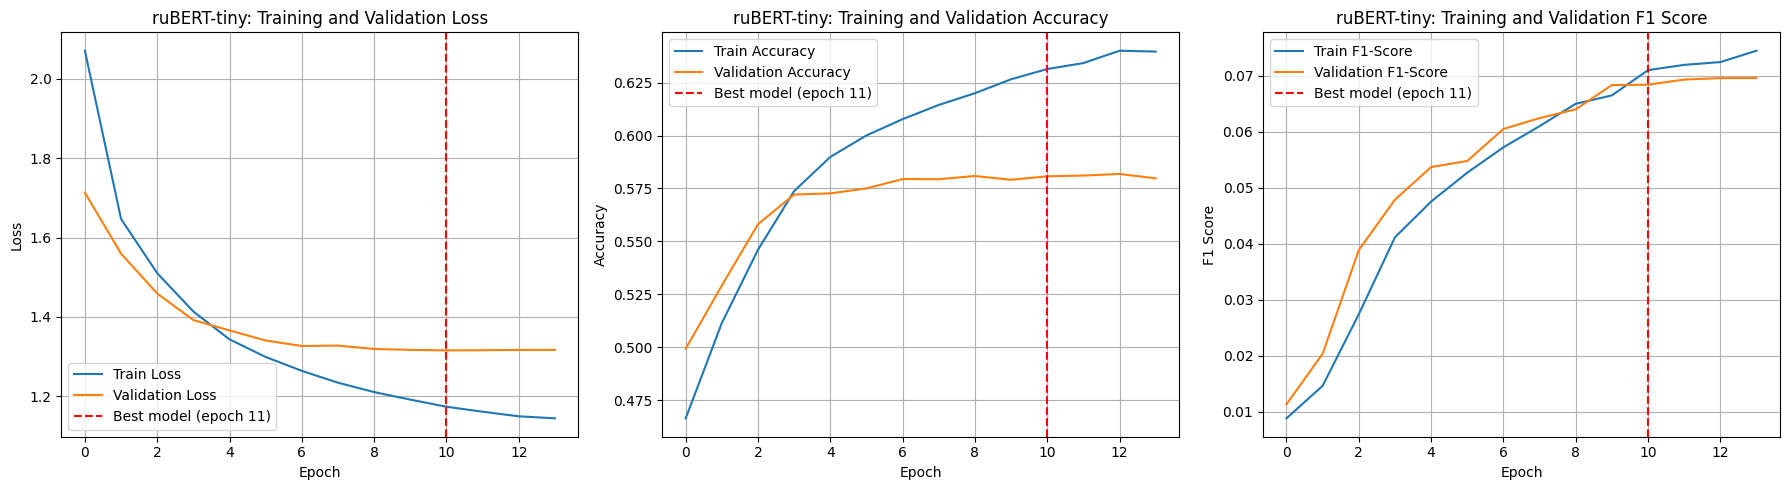

In [91]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


bert_model_name = 'cointegrated/rubert-tiny'
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

train_dataset = BertDataset(train_texts, train_labels, tokenizer)
val_dataset = BertDataset(val_texts, val_labels, tokenizer)
test_dataset = BertDataset(test_texts, test_labels, tokenizer)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = AutoModelForSequenceClassification.from_pretrained(
    bert_model_name,
    num_labels=len(le.classes_)
).to(device)

EPOCHS = 15 
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

rubert_train_losses, rubert_val_losses = [], []
rubert_train_accs, rubert_val_accs = [], []
rubert_train_f1s, rubert_val_f1s = [], []

best_val_loss = float('inf')
epochs_no_improve = 0
patience = 3 
best_bert_model_path = 'best_bert_model.pth'

for epoch in range(1, EPOCHS + 1):
    print(f"\n--- Epoch {epoch}/{EPOCHS} ---")
    train_loss, train_acc, train_f1 = train_epoch_bert(model, train_loader, optimizer, scheduler, device)
    
    val_loss, val_acc, val_f1 = eval_model_bert(model, val_loader, device)
    
    rubert_train_losses.append(train_loss)
    rubert_val_losses.append(val_loss)
    rubert_train_accs.append(train_acc)
    rubert_val_accs.append(val_acc)
    rubert_train_f1s.append(train_f1)
    rubert_val_f1s.append(val_f1)
    
    print(f"  Train -> loss: {train_loss:.4f}, acc: {train_acc:.4f}, f1: {train_f1:.4f}")
    print(f"  Valid -> loss: {val_loss:.4f}, acc: {val_acc:.4f}, f1: {val_f1:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_bert_model_path)
        print(f"  Улучшение на валидации! Модель сохранена")
    else:
        epochs_no_improve += 1
        print(f"  Улучшения на валидации нет {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
        print(f"Ранняя остановка на эпохе {epoch}. Лучшая val loss: {best_val_loss:.4f}")
        break


print("\nОбучение завершено.")
print(f"Загрузка лучшей BERT модели из {best_bert_model_path} для финальной оценки.")
model.load_state_dict(torch.load(best_bert_model_path))

test_loss, test_acc, test_f1 = eval_model_bert(model, test_loader, device)

print("\n--- Финальные метрики лучшей BERT модели на тестовых данных ---")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} | Test F1-Score (macro): {test_f1:.4f}")


plt.figure(figsize=(18, 5))
best_epoch = np.argmin(rubert_val_losses)

plt.subplot(1, 3, 1)
plt.plot(rubert_train_losses, label='Train Loss')
plt.plot(rubert_val_losses, label='Validation Loss')
plt.axvline(best_epoch, linestyle='--', color='r', label=f'Best model (epoch {best_epoch+1})')
plt.title('ruBERT-tiny: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(rubert_train_accs, label='Train Accuracy')
plt.plot(rubert_val_accs, label='Validation Accuracy')
plt.axvline(best_epoch, linestyle='--', color='r', label=f'Best model (epoch {best_epoch+1})')
plt.title('ruBERT-tiny: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(rubert_train_f1s, label='Train F1-Score')
plt.plot(rubert_val_f1s, label='Validation F1-Score')
plt.axvline(best_epoch, linestyle='--', color='r', label=f'Best model (epoch {best_epoch+1})')
plt.title('ruBERT-tiny: Training and Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()